# Lab course: Computational statistical mechanics

# Machine learning of the simple Ising model in 2D

## 1. Code for a MC Ising simulation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd

### *1.1 Initialization and calculation of the Energy difference*

In [2]:
@njit
def init(n=10, random=False):
    grid = np.zeros(shape=(n,n), dtype = np.int64)
    if random:
        grid = np.random.randint(0,2,size = (n,n))
    grid = np.where(grid==0,-1,grid)
    return grid

In [3]:
@njit
def calculate_energy_diff(x,grid,J=1,B=0):
    H = np.zeros(2)
    y = np.where(x==grid.shape[0]-1,-1,x)
    j = 1
    for i in range(2):
        S = 0
        S+= grid[x[0],x[1]]*grid[x[0]-1,x[1]]*j
        S+= grid[x[0],x[1]]*grid[y[0]+1,x[1]]*j
        S+= grid[x[0],x[1]]*grid[x[0],x[1]-1]*j
        S+= grid[x[0],x[1]]*grid[x[0],y[1]+1]*j
        H[i] = S
        j = -1
    H_diff = -J*(H[1] - H[0])+ B*2*grid[x[0],x[1]]
    return H_diff

### *1.2 Monte Carlo simulation* 

In [4]:
@njit
def spin_flip(grid, T, J ,B):
    M_diff = 0
    x = np.random.randint(0,grid.shape[0],size=2)
    H_diff = calculate_energy_diff(x,grid, J, B)
    if T == 0:
        if H_diff <= 0:
            grid[x[0],x[1]] = grid[x[0],x[1]]*-1
            M_diff = grid[x[0],x[1]]*-2
          
    else:
        r = np.random.random()
        if r < np.exp(-H_diff/T):
            grid[x[0],x[1]] = grid[x[0],x[1]]*-1
            M_diff = grid[x[0],x[1]]*-2

    return M_diff

### *1.3 Functions to calculate the data for the plots*

In [5]:
@njit
def m_of_t(steps, T, N, random, J, B, val = 1):
    n_acc = 0
    M = np.zeros(steps)
    grid = init(N, random)
    grid = grid * val
    M[0] = np.sum(grid)/N**2
    for j in range(1,steps):
        M_diff = spin_flip(grid,T, J, B)
        M[j] = M[j-1] - M_diff/N**2
    return M, grid

In [6]:
@njit
def m_of_Temp(T, N, steps, equi, J, B, random = True):
    M_of_T = np.zeros(T.size)
    for i in range(T.size):
        M = np.abs(m_of_t(steps, T[i], N, random, J, B)[0])
        M_of_T[i] = np.mean(M[equi:])
    return M_of_T

In [7]:
@njit
def m_of_B(T, N, steps, equi, J, B, both = True, random = True):
    M_of_B = np.zeros((2,B.size))
    for i in range(B.size):
        M = m_of_t(steps, T, N, random, J, B[i])[0]
        M_of_B[0,i] = np.mean(M[equi:])
    if both:
        for i,j in enumerate(B,0):
            M = m_of_t(steps, T, N, random, J, j, val = -1)[0]
            M_of_B[1,i] = np.mean(M[equi:])
    return M_of_B

In [8]:
@njit
def susceptibility(N,T,steps, equi, B=0, J=1,random = True):
    susc = np.zeros(T.size)
    for i in range(T.size):
        M = m_of_t(steps, T[i], N, random, J, B)[0]
        susc[i] = 1/T[i]*(np.mean(M[equi:]**2)-np.mean(M[:equi])**2)
    return susc

In [9]:
@njit
def create_set(n : int, T : np.array, N : int, steps, random = True, J = 1):
    label = np.zeros((n*T.shape[0],3))
    grid = np.zeros((1,N**2), dtype = np.int64)
    for i in range(T.shape[0]*n):
        val = np.random.choice(np.array([1,-1]))
        m = m_of_t(steps, T[int(i/n),0], N, random, J, 0, val)[1].flatten()
        m = np.expand_dims(m,0)
        grid = np.vstack((grid,m))
        label[i] = T[int(i/n)]
    return grid,label

In [10]:
def plot_m(steps, T, N, random, J, B):
    """
    Plots M as a function of the timesteps t.
    """
    M, grid  = m_of_t(steps, T, N, random, J, B)
    steps = M.size
    fig, ax = plt.subplots()
    ax.plot(np.arange(0,steps,1), M,'-.')
    ax.set_xlabel('Steps t')
    ax.set_ylabel('Magnetization M')
    ax.set_title(f'Magnetization M(t)')
    plt.show()
    return grid

# Machine Learning

The following parameters were taken from the paper 'A high-bias, low-variance introduction to Machine Learning
for physicists' <br> (https://www.sciencedirect.com/science/article/pii/S0370157319300766?via%3Dihub) <br><br>
Considering a 40x40 square Lattice. $\newline$
Preparing $10^4$ states at every fixed temperature. (current 600) (200,600,1200) $\newline$
0 if the state is disordered and 1 if it is ordered. $\newline$
T/J < 2.0 ordered $\newline$
T/J > 2.5 disordered $\newline$
2.0 < T/J < 2.5 near critical$\newline$

For ordered3 used: 1000000 timesteps and ordered init <br>
For critical3 used: 5000000 timesteps and ordered init <br>

In [4]:
N = 40 #40
T = np.linspace(0.25,4.0,16)#16
J = 1
B = 0
steps = 1000000
n = 600
print(f'Temperatures used:\n{T}')

Temperatures used:
[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.  ]


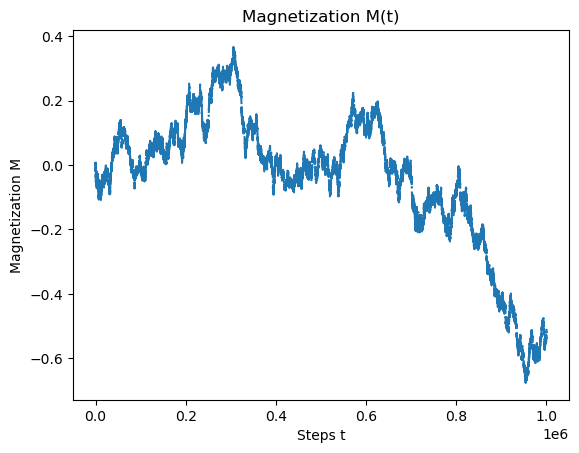

In [16]:
grid = plot_m(steps, 2.25, N, True, J, B)

In [29]:
# ordered set
T = np.array([[0.25, 0, 1],[0.5, 1, 1],[0.75, 2, 1],[1., 3, 1],[1.25, 4, 1],[1.5, 5, 1],[1.75, 6, 1]])
ordered_X, ordered_Y = create_set(n, T, N, steps, random = False) 
ordered_X = np.delete(ordered_X,0,0)

In [6]:
ordered_X[0]

array([1, 1, 1, ..., 1, 1, 1])

In [7]:
M = np.sum(ordered_X[:4200], axis=1)/N**2

(0.9, 1.0)

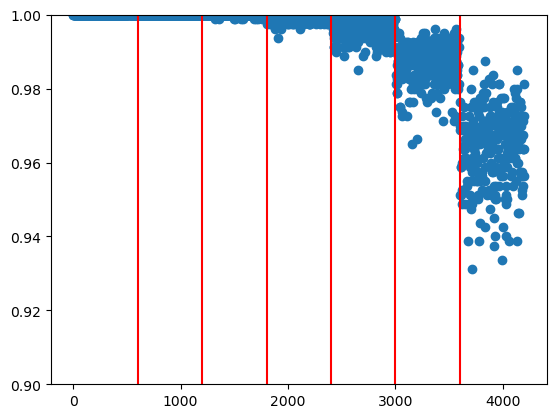

In [9]:
plt.scatter(np.arange(len(M)),M)
plt.vlines(600,0.9,1, color = 'red')
plt.vlines(1200,0.9,1, color = 'red')
plt.vlines(1800,0.9,1, color = 'red')
plt.vlines(2400,0.9,1, color = 'red')
plt.vlines(3000,0.9,1, color = 'red')
plt.vlines(3600,0.9,1, color = 'red')
plt.ylim({0.9,1})

In [46]:
dfx = pd.DataFrame(critical_X)
dfy = pd.DataFrame(critical_Y)

In [47]:
dfx.to_csv('critical_X3.csv', mode='a', index=False, header=False)
dfy.to_csv('critical_Y3.csv', mode='a', index=False, header=False)

In [48]:
x = pd.read_csv("critical_X3.csv")
x

,0,1,2,3,4,5,6,7,8,9,...,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,-1,-1,-1,-1,1,1,1,1,1,-1,...,1,-1,1,1,1,1,1,1,1,1
16196,-1,1,-1,-1,-1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,-1,1,-1,-1
16197,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
16198,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,-1,-1


In [49]:
(16200/3)/600

9.0

In [42]:
# critical set
T = np.array([[2, 7, 1],[2.25,8,1],[2.5,9,0]])
critical_X, critical_Y = create_set(n, T, N, steps, J = 1, random = False)
critical_X = np.delete(critical_X,0,0)

In [43]:
critical_X.shape

(1800, 1600)

In [44]:
M = np.sum(critical_X, axis=1)/N**2

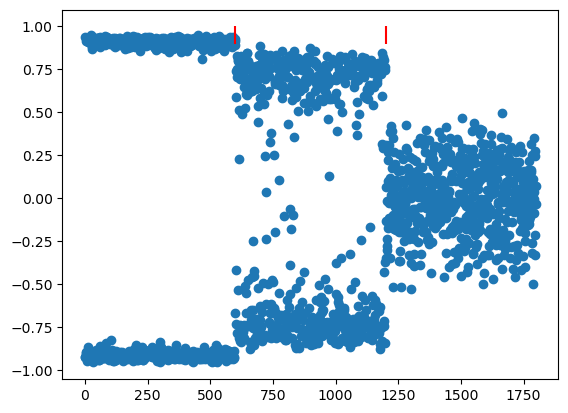

In [45]:
plt.scatter(np.arange(len(M)),M)
plt.vlines(600,0.9,1, color = 'red')
plt.vlines(1200,0.9,1, color = 'red')

In [28]:
# disordered set
T = np.array([[2.75, 10, 0],[3,11,0],[3.25, 12, 0],[3.5, 13, 0],[3.75, 14, 0],[4, 15, 0]])
disordered_X, disordered_Y = create_set(n, T, N, steps, J = 1) 
disordered_X = np.delete(disordered_X,0,0)

In [29]:
disordered_X.shape

(3600, 1600)

In [5]:
ordered_X = np.array(pd.read_csv("ordered_X3.csv"))
ordered_Y = np.array(pd.read_csv("../ordered_Y2.csv"))
critical_X = np.array(pd.read_csv("critical_X3.csv"))
critical_Y = np.array(pd.read_csv("../critical_Y2.csv"))
disordered_X = np.array(pd.read_csv("../disordered_X2.csv"))
disordered_Y = np.array(pd.read_csv("../disordered_Y2.csv"))

In [52]:
ordered_M = np.sum(ordered_X,axis = 1)/N**2
critical_M =  np.sum(critical_X,axis = 1)/N**2
disordered_M = np.sum(disordered_X,axis = 1)/N**2

In [53]:
ordered_M

array([ 1.     ,  1.     , -1.     , ..., -0.955  ,  0.95625, -0.95125])

In [1]:
ind = 600

In [2]:
plt.scatter(np.arange(len(ordered_M))[:ind],ordered_M[:ind])

NameError: name 'plt' is not defined

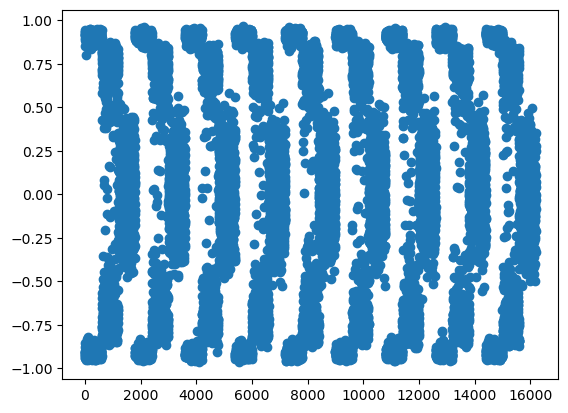

In [56]:
plt.scatter(np.arange(len(critical_M)),critical_M)

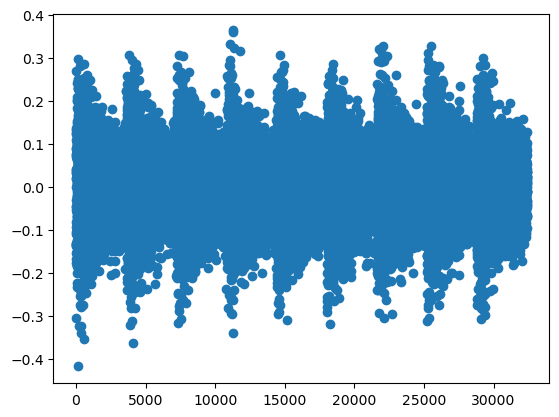

In [57]:
plt.scatter(np.arange(len(disordered_M)),disordered_M)

## Logistic regression with $y_i = \{0,1\}$<br>

In this part we would like to use a binary machine learning model to predict weither the given state is ordered (1) or unordered (0). <br>
As a model we use logistic regression. The cross entropy then gets solved with an SGD (stochastic gradient descent) and a linear approach.

At first we look at the regularization parameter $\lambda$ and how it affects SGD and the linear solver.

Then we would like to see what role the size of the training/test sets plays in the accuracy of the logistic regression.

### Effects of the regularisation parameter $\lambda$ on SGD and linear solver

In [11]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [12]:
# define training and test data sets
X=np.concatenate((ordered_X,disordered_X))
Y=np.concatenate((ordered_Y[:,2],disordered_Y[:,2]))

NameError: name 'ordered_X' is not defined

In [ ]:
###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
#Y_train = np.reshape(Y_train,(1300))

In [ ]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(critical_X.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

In [ ]:
# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

In [ ]:
# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1000,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(critical_X,critical_Y[:,2])
 

   
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=400, 
                                           shuffle=True, random_state=1, learning_rate='optimal')#100

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(critical_X,critical_Y[:,2])
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

In [ ]:
# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

### Depending on the sample size

In [14]:
#define number of different sample sizes
n_sets = 8
n_configs = 600
###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# define regularisation parameter
lmbda=1e-2

# preallocate data
train_accuracy=np.zeros(n_sets,np.float64)
test_accuracy=np.zeros(n_sets,np.float64)
critical_accuracy=np.zeros(n_sets,np.float64)

train_accuracy_SGD=np.zeros(n_sets,np.float64)
test_accuracy_SGD=np.zeros(n_sets,np.float64)
critical_accuracy_SGD=np.zeros(n_sets,np.float64)

n_config_T = np.linspace(n_configs,n_sets*n_configs,n_sets)

In [15]:
print('Number of configs per T in total (ordered):', ordered_X.shape[0]/7)
print('Number of configs per T in total (disordered):', disordered_X.shape[0]/6)
print('Number of configs per T in total (critical):', critical_X.shape[0]/3)
print()
print('Number of sets:', n_sets)
print()
print('Number of configs per T in one set:', n_configs)

Number of configs per T in total (ordered): 5400.0
Number of configs per T in total (disordered): 5400.0
Number of configs per T in total (critical): 5400.0

Number of sets: 8

Number of configs per T in one set: 600


In [16]:
ordered_X.shape

(37800, 1600)

In [16]:
#number of configs per T * numer of different T
k_ord = n_configs*7
k_disord = n_configs*6

#loop over sets
for i in range(n_sets):
 
    X=np.concatenate((ordered_X[:k_ord*(i+1)],disordered_X[:k_disord*(i+1)]))
    Y=np.concatenate((ordered_Y[:k_ord*(i+1),2],disordered_Y[:k_disord*(i+1),2]))

    # pick random data points from ordered and disordered states 
    # to create the training and test sets
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
  

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1000,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(critical_X,critical_Y[:,2])
    
    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=500, 
                                           shuffle=True, random_state=1, learning_rate='optimal')#100

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(critical_X,critical_Y[:,2])
 
    print('number of configs per T:', 600*(i+1))
    
    print(f'finished computing %i/{n_sets} iterations' %(i+1))

number of configs per T: 600
finished computing 1/8 iterations
number of configs per T: 1200
finished computing 2/8 iterations
number of configs per T: 1800
finished computing 3/8 iterations
number of configs per T: 2400
finished computing 4/8 iterations
number of configs per T: 3000
finished computing 5/8 iterations
number of configs per T: 3600
finished computing 6/8 iterations
number of configs per T: 4200
finished computing 7/8 iterations
number of configs per T: 4800
finished computing 8/8 iterations


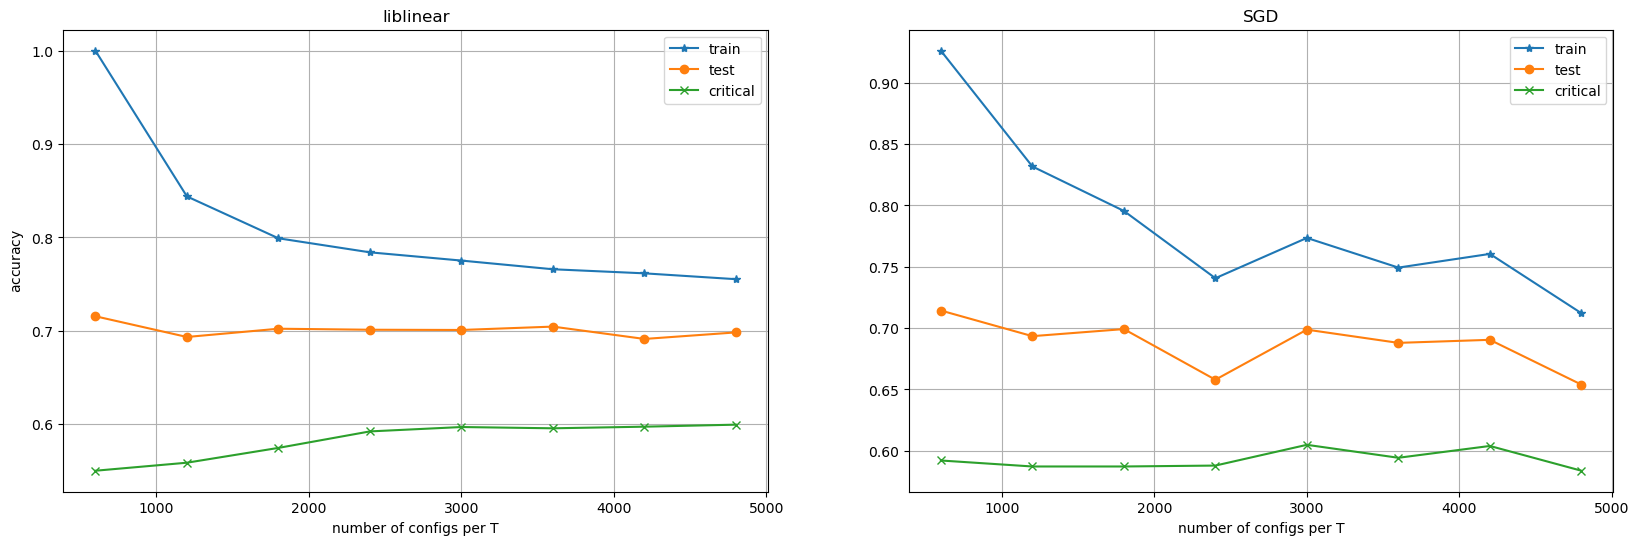

In [17]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(n_config_T,train_accuracy,marker = '*',label='train')
ax[0].plot(n_config_T,test_accuracy,marker = 'o',label='test')
ax[0].plot(n_config_T,critical_accuracy,marker = 'x',label='critical')

ax[0].set_title('liblinear')
ax[0].set_xlabel('number of configs per T')
ax[0].set_ylabel('$\\mathrm{accuracy}$')

ax[0].grid()
ax[0].legend()

ax[1].plot(n_config_T,train_accuracy_SGD,marker = '*',label='train')
ax[1].plot(n_config_T,test_accuracy_SGD,marker = 'o',label='test')
ax[1].plot(n_config_T,critical_accuracy_SGD,marker = 'x',label='critical')

ax[1].set_title('SGD')
ax[1].set_xlabel('number of configs per T')

ax[1].grid()
ax[1].legend()

plt.show()

In [20]:
n_sims = 4

train_accuracy_SGD=np.zeros((n_sims,n_sets),np.float64)
test_accuracy_SGD=np.zeros((n_sims,n_sets),np.float64)
critical_accuracy_SGD=np.zeros((n_sims,n_sets),np.float64)

#number of configs per T * numer of different T
k_ord = n_configs*7
k_disord = n_configs*6

#loop over sims
for j in range(n_sims):
    #loop over sets
    for i in range(n_sets):
        
        X=np.concatenate((ordered_X[:k_ord*(i+1)],disordered_X[:k_disord*(i+1)]))
        Y=np.concatenate((ordered_Y[:k_ord*(i+1),2],disordered_Y[:k_disord*(i+1),2]))

        # pick random data points from ordered and disordered states 
        # to create the training and test sets
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
    
        # define SGD-based logistic regression
        logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=500, 
                                           shuffle=True, random_state=1, learning_rate='optimal')#100

        # fit training data
        logreg_SGD.fit(X_train,Y_train)

        # check accuracy
        train_accuracy_SGD[j,i]=logreg_SGD.score(X_train,Y_train)
        test_accuracy_SGD[j,i]=logreg_SGD.score(X_test,Y_test)
        critical_accuracy_SGD[j,i]=logreg_SGD.score(critical_X,critical_Y[:,2])
 
        #print('number of configs per T:', 600*(i+1))
    
    print(f'finished computing %i/{n_sims} iterations' %(j+1))

finished computing 1/8 iterations
finished computing 2/8 iterations
finished computing 3/8 iterations
finished computing 4/8 iterations


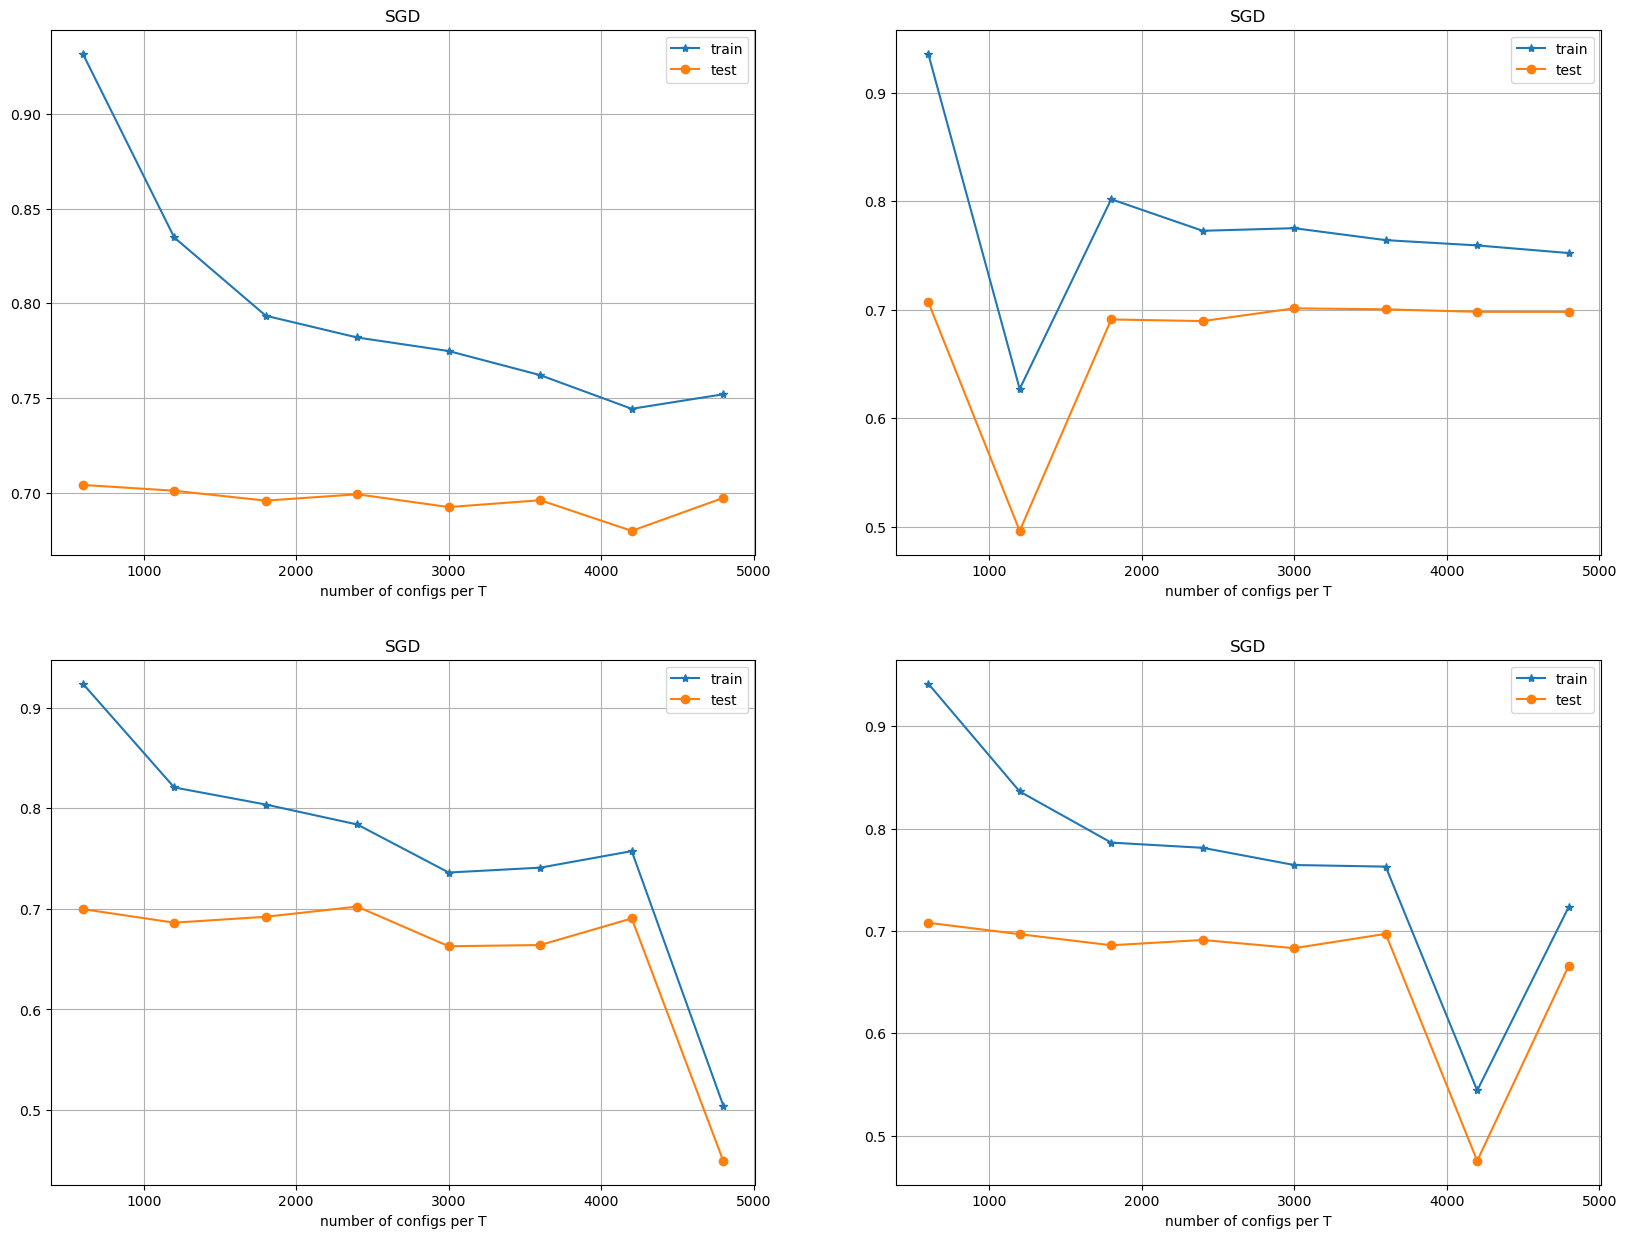

In [21]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

for i, axis in enumerate(ax.flatten()):
    axis.plot(n_config_T,train_accuracy_SGD[i,:],marker = '*',label='train')
    axis.plot(n_config_T,test_accuracy_SGD[i,:],marker = 'o',label='test')
    #axis.plot(n_config_T,critical_accuracy_SGD[i,:],marker = 'x',label='critical')

    axis.set_title('SGD')
    axis.set_xlabel('number of configs per T')

    axis.grid()
    axis.legend()

plt.show()

In [41]:
# Read in precalculated data 
data_Linear = np.array(pd.read_csv("LogisticRegressionScaleSetsLinear.csv"))
data_SGD = np.array(pd.read_csv("LogisticRegressionScaleSetsSGD.csv"))

n_config_T = data_Linear[0,:]
train_accuracy = data_Linear[1,:]
test_accuracy = data_Linear[2,:]
critical_accuracy = data_Linear[3,:]

train_accuracy_SGD = data_SGD[1,:]
test_accuracy_SGD = data_SGD[2,:]
critical_accuracy_SGD = data_SGD[3,:]

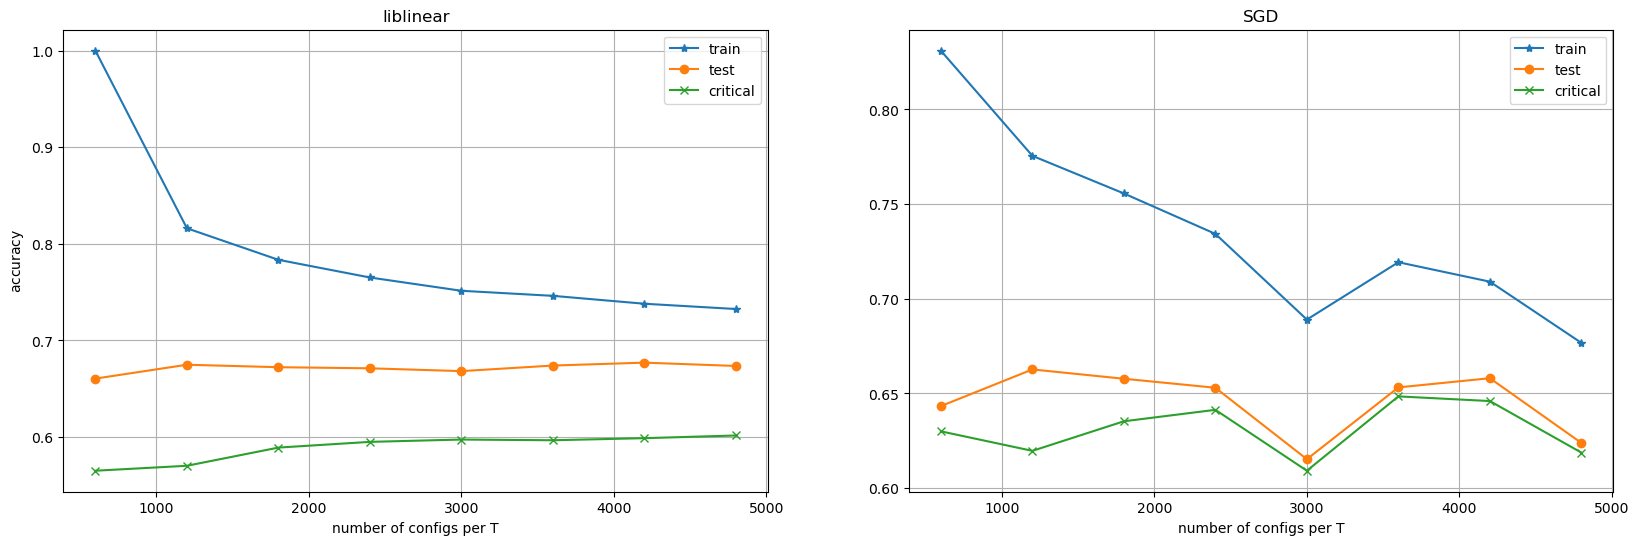

In [54]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(n_config_T,train_accuracy,marker = '*',label='train')
ax[0].plot(n_config_T,test_accuracy,marker = 'o',label='test')
ax[0].plot(n_config_T,critical_accuracy,marker = 'x',label='critical')

ax[0].set_title('liblinear')
ax[0].set_xlabel('number of configs per T')
ax[0].set_ylabel('$\\mathrm{accuracy}$')

ax[0].grid()
ax[0].legend()

ax[1].plot(n_config_T,train_accuracy_SGD,marker = '*',label='train')
ax[1].plot(n_config_T,test_accuracy_SGD,marker = 'o',label='test')
ax[1].plot(n_config_T,critical_accuracy_SGD,marker = 'x',label='critical')

ax[1].set_title('SGD')
ax[1].set_xlabel('number of configs per T')

ax[1].grid()
ax[1].legend()

plt.show()

## Logistic regression with $y_i = \{T_0, ... T_n\}$

In [13]:
# define training and test data sets
X=np.concatenate((ordered_X,disordered_X,critical_X))
Y=np.concatenate((ordered_Y[:,1],disordered_Y[:,1],critical_Y[:,1]))

#configs per Temperature
n_configs = critical_X.shape[0]/3

In [16]:
###### define ML parameters
num_classes= len(T)
train_to_test_ratio=0.5 # training samples

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

In [17]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print()
print('Number of configs per T in one set:', n_configs)

X_train shape: (43200, 1600)
Y_train shape: (43200,)

43200 train samples
43200 test samples

Number of configs per T in one set: 5400.0


In [18]:
# define regularisation parameter
#lmbdas=np.logspace(-2,2,5)
lmbdas = np.array([0])
# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)


train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

In [19]:
# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/1.0,random_state=1,verbose=0,max_iter=1000,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
 

   
    print('accuracy: train, test')
    print('liblin: %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i] ))

    # define SGD-based logistic regression
    #logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=500, 
     #                                      shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    #logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    #train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    #test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    
    #print('SGD: %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i] ))

    #print(f'finished computing %i/{len(lmbdas)} iterations' %(i+1))

accuracy: train, test
liblin: 0.2627, 0.1353


In [133]:
data = np.array(pd.read_csv("logisticRegressionT2.csv"))

In [46]:
# plot accuracy against regularisation strength
plt.semilogx(data[:,0],data[:,1],'*-b',label='liblinear train')
plt.semilogx(data[:,0],data[:,2],'*-r',label='liblinear test')

plt.semilogx(data[:,0],data[:,3],'*--b',label='SGD train')
plt.semilogx(data[:,0],data[:,4],'*--r',label='SGD test')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

NameError: name 'data' is not defined

In [20]:
X_T=np.concatenate((ordered_X,disordered_X,critical_X))
Y_T=np.concatenate((ordered_Y,disordered_Y,critical_Y))

temp_X = []
temp_Y = []
for i in T:
    ind = np.where(Y_T[:,0] == i)[0]
    temp_X.append(X_T[ind,:])
    temp_Y.append(Y_T[ind,:])

In [22]:
score_per_temp = np.zeros(len(T))
score_per_temp_SGD = np.zeros(len(T))
for i in range(len(T)):
    score_per_temp[i] = logreg.score(temp_X[i],temp_Y[i][:,1])
    #score_per_temp_SGD[i] = logreg_SGD.score(X_T[600*i:600*(i+1),:],Y_T[600*i:600*(i+1),1])

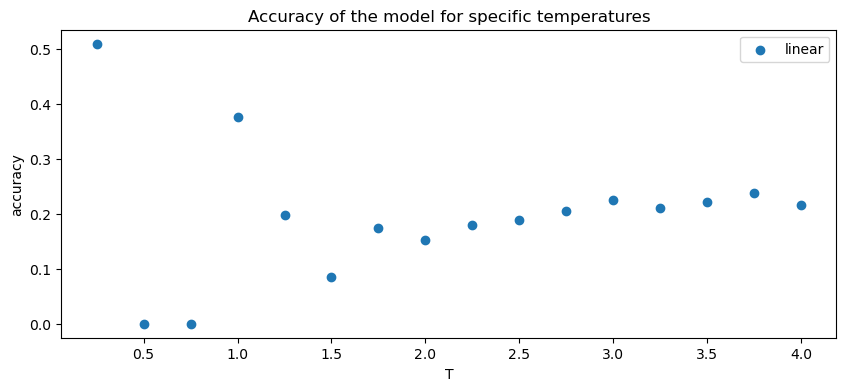

In [23]:
fig, ax = plt.subplots(1, figsize = (10,4))

ax.scatter(T,score_per_temp, label = "linear")
#ax.scatter(T,score_per_temp_SGD, label = "SGD")
ax.set_xlabel("T")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy of the model for specific temperatures")
ax.legend()
plt.show()



In [24]:
predicts = np.empty((len(T),temp_X[0].shape[0]))
#predicts_SGD = np.empty((len(T),temp_X[0].shape[0]))

for i in range(len(T)):
    for j in range(temp_Y[i].shape[0]):
        predicts[i,j] = logreg.predict([temp_X[i][j,:]])
        #predicts_SGD[i,j] = logreg_SGD.predict([temp_X[i][j,:]])

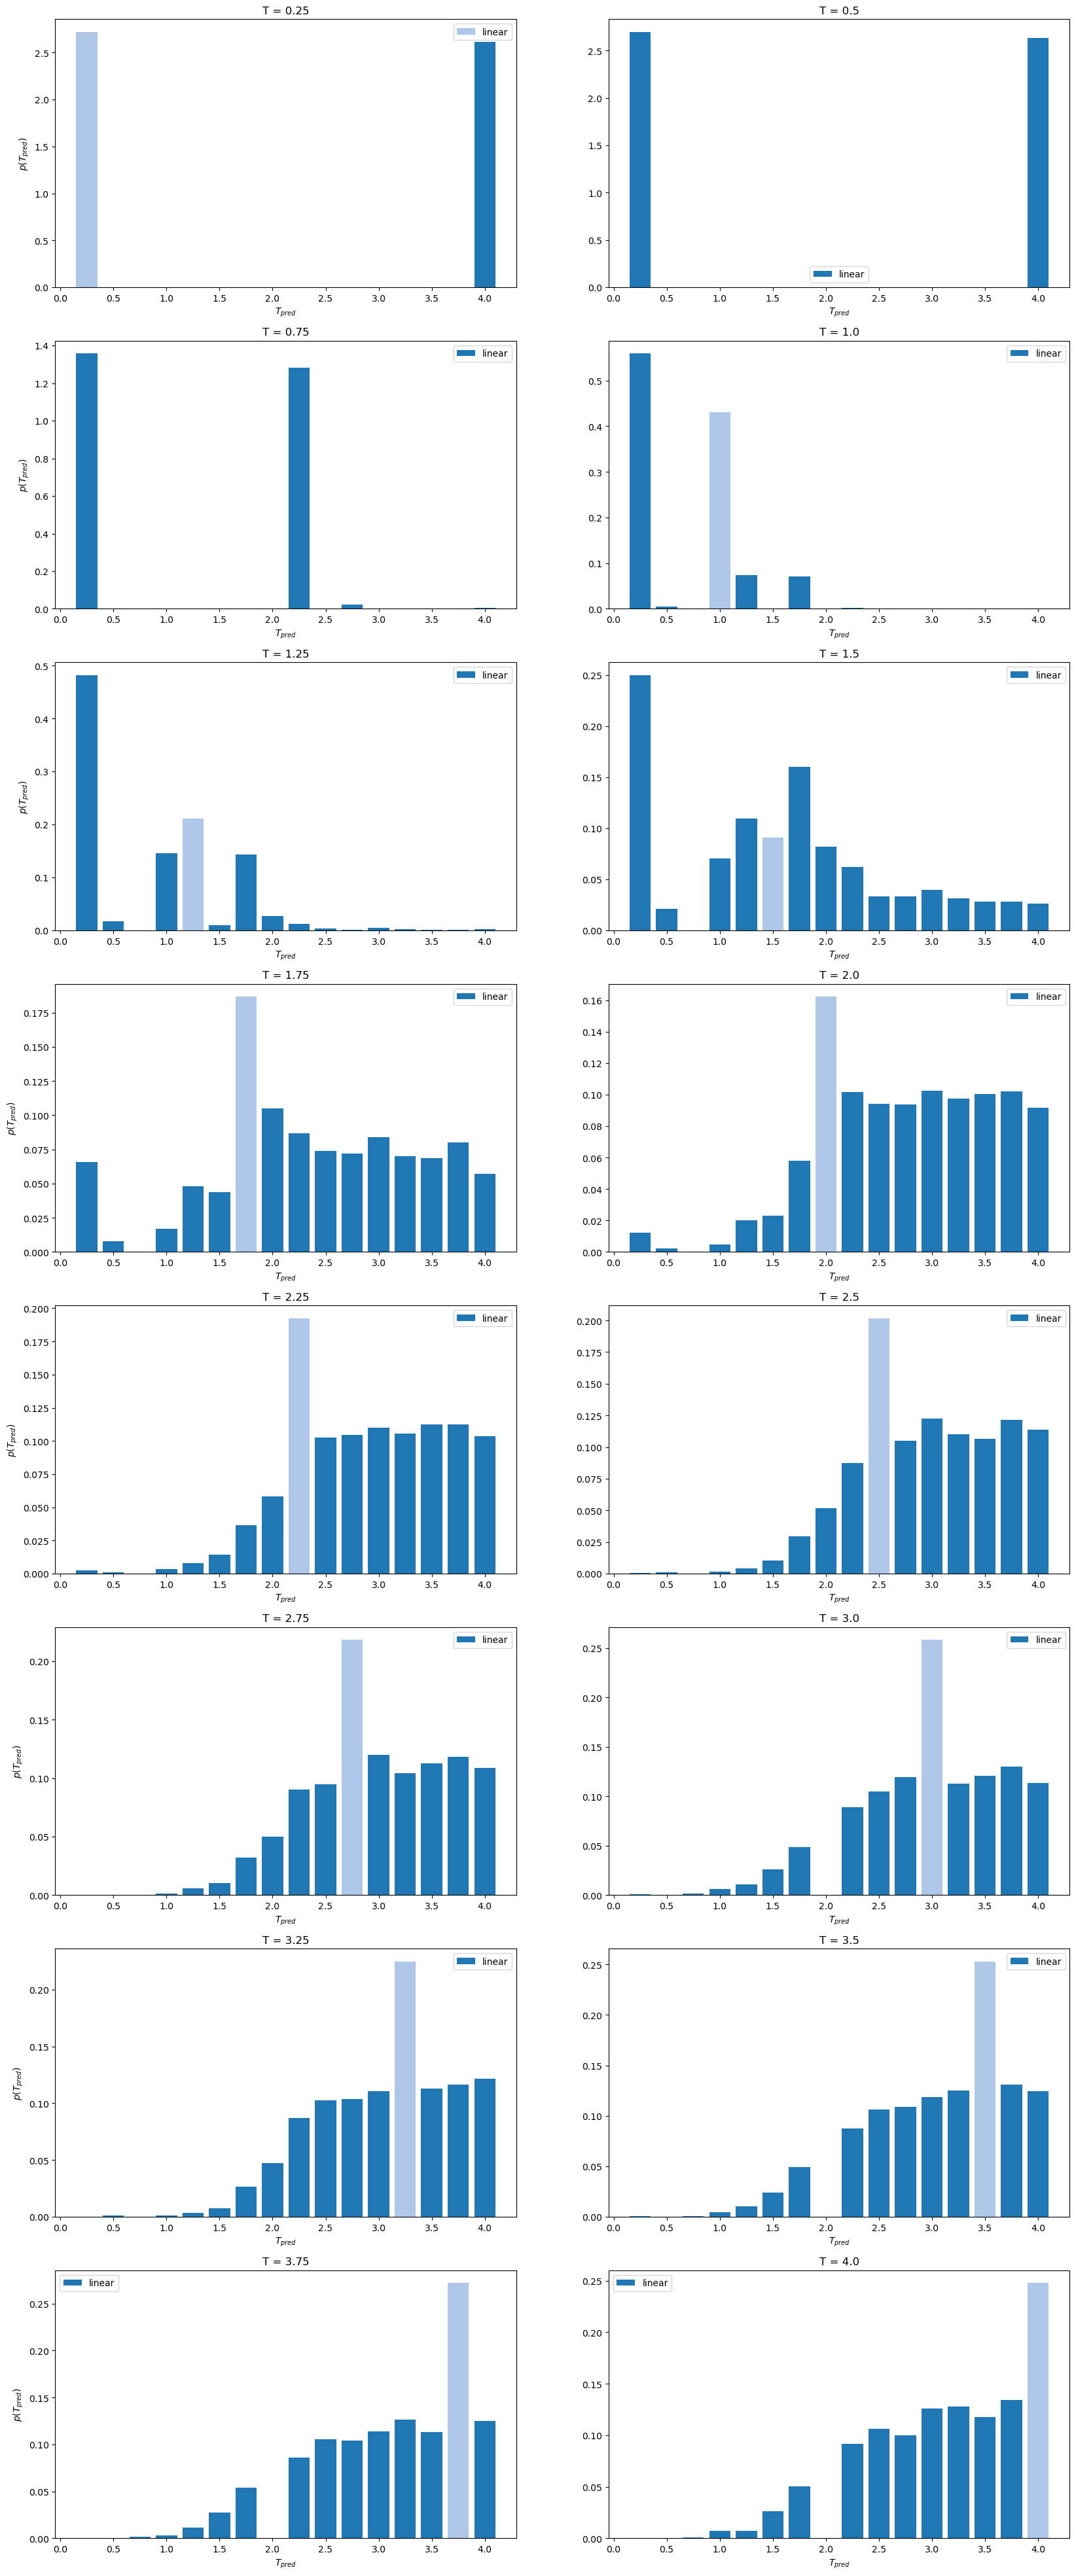

In [26]:
fig,ax = plt.subplots(8,2, figsize = (20,50))
bins = np.arange(16)
cmap = plt.get_cmap('tab20')

for i, axis in enumerate(ax.flatten()):
    c = np.array([cmap(0)] * 16)
    c[i] = cmap(1)
    density, bin_edges = np.histogram(predicts[i,:], 16, density=True)
    #density_SGD, bin_edges = np.histogram(predicts_SGD[i,:], 16, density=True)
    axis.bar(T,density, width = 0.2, label = "linear", color = c)
    #axis.bar(T,density_SGD, width = 0.2, label = "SGD")
    axis.set_title(f"T = {T[i]}")
    axis.set_xlabel("$T_{pred}$")
    axis.legend()
    if i%2 == 0:
        axis.set_ylabel("$p(T_{pred})$")